In [389]:
import pickle
from sklearn import svm
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from astropy.stats import RipleysKEstimator
from sklearn.cluster import AgglomerativeClustering
from scipy import signal, mgrid, exp
from skimage import morphology
from skimage import measure
from collections import Counter
import math

%matplotlib notebook

In [200]:
coord_df = pickle.load(open("coord_df.p", 'rb'))
df_fish = pickle.load(open("df_fish.p", 'rb'))
df_sort = pickle.load(open("df_sort.p", 'rb'))
labels_a = pickle.load(open("labels_a_47.p", 'rb'))
label_colors_hex = pickle.load(open("label_colors_hex_47.p", 'rb'))
label_cells = pickle.load(open("label_cells_47.p", 'rb'))
cell_labels = pickle.load(open("cell_labels_47.p", 'rb'))
cluster_labels = pickle.load(open("cluster_labels_47.p", 'rb'))
df_fish_log = pickle.load(open('df_fish_log.p', 'rb'))
df_fish_size_sqrt = pickle.load(open('df_fish_size_sqrt.p', 'rb'))
cluster_labels = pickle.load(open('cluster_labels_47.p', 'rb'))
type_color= pickle.load(open('type_color_47.p', 'rb'))

# Ripley's K

In [ ]:
x_min = coord_df.loc['X'].min()
x_max = coord_df.loc['X'].max()
y_min = coord_df.loc['Y'].min()
y_max = coord_df.loc['Y'].max()
area = ((x_max-x_min)*(y_max-y_min))
Kest = RipleysKEstimator(area, x_max, y_max, x_min, y_min)
radii = np.linspace(1000,20000, 100)

plt.figure()
colors = np.arange(0, 1, 1/len(np.unique(labels_a)))
cmap = matplotlib.cm.get_cmap('prism')

RK_3000 = []
RK_10000 = []
for i in np.sort(np.unique(labels_a)):
    estimate =  Kest(data=np.array(coord_df.loc[:,label_cells[i]].T), radii=radii, mode='none')
    RK_3000.append(estimate[np.argmin(np.abs(radii - 3000))]) #Get the estimate of the radii closest to 3000 and append list
    RK_10000.append(estimate[np.argmin(np.abs(radii - 10000))]) #Get the estimate of the radii closest to 10000 and append list
    plt.plot(radii, estimate, color=cmap(colors[i]))

plt.title("Ripley's K for different radii")
plt.xlabel('Radius in pixels')
    

In [3]:
def plot_cell_pos(coordinate_df, cell_ids=None, cell_of_interest=None, color='gray', color_highlight1='r', color_highlight2='r', s=5, standalone = True, mode='Highlight'):
    """
    Plot the centroids of all cells in grey. A selection of cells can be made red.
    And one cell of interest can be shown larger with a white border around.
    Input:
    `coordinate_df`(pd df): Pandas df with cells in columns, and 'X' & 'Y' as rows.
    `cell_ids`(list): If selection of cells to plot, enter a list of cell ids. Default = None
    `color`(str): color of cells, default gray
    `s`(float): Size of dots. Default = 5
    `stanalone`(bool): If true it creates a figure. If false it can be used as subplot
    `mode`(str): if 'highlight' it is possible to highlight a group of cells and/or one cell
    `color_highlight1`: color of group of cells. default='r' 
    `color_highlight2`: color of single cells. default='r'
    
    """
    if standalone == True:
        plt.figure(figsize=(7,7))
        
    if mode.lower() == 'tsne':
        plt.scatter(coordinate_df.loc['X',:], coordinate_df.loc['Y',:], linewidths=0, c=color, s=s)
    
    if mode.lower() == 'highlight':
        plt.scatter(coordinate_df.loc['X',:], coordinate_df.loc['Y',:], linewidths=0, c=color, s=s)
        if cell_ids != None:
            plt.scatter(coordinate_df.loc[:,cell_ids].loc['X'], coordinate_df.loc[:,cell_ids].loc['Y'], color=color_highlight1, s=s*2)
        if cell_of_interest != None:
            plt.scatter(coordinate_df.loc[:,cell_of_interest][0], coordinate_df.loc[:,cell_of_interest][1], color=color_highlight2, s=s*8, lw=2, edgecolor='w')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.gca().axis('equal')
    plt.xlim([coordinate_df.loc['X'].max(), coordinate_df.loc['X'].min()])
    plt.ylim([coordinate_df.loc['Y'].max(), coordinate_df.loc['Y'].min()])
    plt.gca().patch.set_facecolor((.9,.9,.9))
    
#plot_cell_pos(coord_df, cell_ids=None, cell_of_interest='7442', s=10, standalone=True, mode='Highlight')

In [ ]:
plt.figure(figsize=(20,12))
n_clusters = len(np.unique(labels_a))
gs = plt.GridSpec(5, int(n_clusters/5) + (n_clusters % 5 > 0))

for i, c in enumerate(np.argsort(RK_10000)[::-1]):
    plt.subplot(gs[i])
    filt = np.sort(labels_a) == c
    plot_cell_pos(coord_df, cell_ids=list(df_sort.columns[filt]), cell_of_interest=None, s=1, standalone=False, color_highlight1='r')
    ax = plt.gca()
    for tl in ax.get_xticklabels() + ax.get_yticklabels():
        tl.set_visible(False)
    #ax.set_title('Cluster {}'.format(c))
    ax.set_title('{}\n{} {}'.format("{:.2e}".format(RK_10000[c]),c, cluster_labels[c]), fontsize=6)
    

# SVM spatial classification

In [ ]:
X_loc = coord_df.loc[:,df_sort.columns].values.T
y_loc = labels_a

In [ ]:
cloud = 200
grid_c = np.zeros([16, 2])

for i, p in enumerate(grid_c):
    x = (int(i/4))*10000
    y = [x*10000 for x in [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]]
    y = y[i]
    grid_c[i] = x,y

    
grid_p = np.zeros([len(grid_c)*cloud, 2])
label_p = []
for i, p in enumerate(grid_c):
    for n in range(cloud):
        label_p.append(i)
        pos = i*cloud + n
        x_shift = np.random.normal(0, scale=1000)
        y_shift = np.random.normal(0, scale=1000)
        grid_p[pos] = p[0]+x_shift, p[1]+y_shift
        
def cell_scatter(arr2D, color='blue'):
    plt.figure()
    for i in range(len(arr2D)):
        plt.scatter(arr2D[i][0], arr2D[i][1], c=color)
        
cell_scatter(grid_p)

In [ ]:
def make_meshgrid(x, y, h=1000, extra_space=0):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional
    extra_space: Added boarders around the dataset

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - extra_space , x.max() + extra_space
    y_min, y_max = y.min() - extra_space , y.max() + extra_space
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [ ]:
X0, X1 = X_loc[:, 0], X_loc[:, 1]
xx, yy = make_meshgrid(X0, X1, h=1000, extra_space=10000)

In [ ]:
model = svm.SVC(C=10, kernel='rbf', degree=3, gamma=0.000001, coef0=0.0, shrinking=True, 
                probability=False, tol=0.001, cache_size=200, class_weight=None, 
                verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
clf = model.fit(X_loc, y_loc)
#clf = model.fit(grid_p, label_p)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
print(len(np.unique(Z)))
fig, ax = plt.subplots(figsize=(5,5))
ax.contourf(xx, yy, Z, cmap=plt.cm.jet)
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_aspect('equal')

# Spatial clustering

In [567]:
#Transform the cell location to coordinates of a grid with a certain tile size
tile_size = 250
cell_grid = coord_df.copy() / tile_size
cell_grid = cell_grid.astype(int)

print('X: ',np.unique(cell_grid.loc['X']))
print('Y: ',np.unique(cell_grid.loc['Y']))

X:  [  4   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126]
Y:  [  6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23
  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 1

number of tiles in grid:  25578
1.07490147594
0.982349298557
1.00062906531


<IPython.core.display.Javascript object>


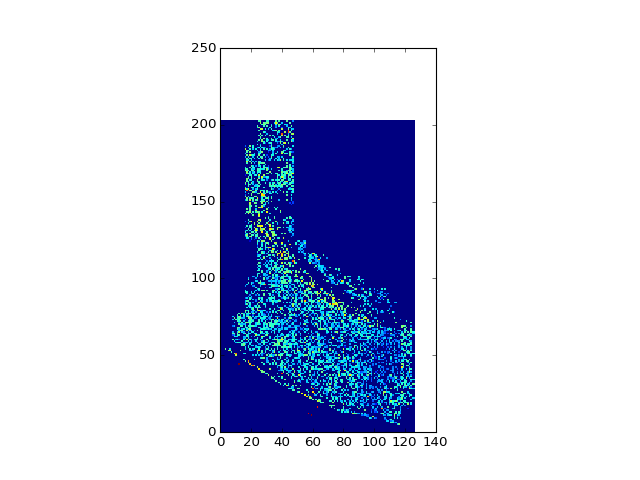

In [568]:
#Make a dataframe for the grid
grid_x, grid_y = max(np.unique(cell_grid.loc['X'])), max(np.unique(cell_grid.loc['Y']))
grid_df = pd.DataFrame(data=np.zeros((df_fish.shape[0], grid_x * grid_y)), index=df_fish.index)
print('number of tiles in grid: ', grid_x * grid_y)

#Fil the grid with the counts of the cells within
grid_cell_n = np.zeros((1, grid_x * grid_y))

for c in df_fish.columns:
    cell_location = ((cell_grid[c]['X'])) + ((cell_grid[c]['Y'] - 1) * (grid_x)-1)
    grid_df[cell_location] = grid_df[cell_location] + df_fish_size_sqrt[c]
    grid_cell_n[0,cell_location] += 1

grid_cell_n = np.array(grid_cell_n)

#Normalize for the number of cells
grid_df = grid_df.div(grid_cell_n[0], axis='columns')
grid_df = grid_df.fillna(0)

print(grid_df.loc['Hybridization1_Tbr1'].max())
print(grid_df.loc['Hybridization1_Aldoc'].max())
print(grid_df.loc['Hybridization1_Foxj1'].max())

#For visualization, sum the expression of all cells and make a pcolor
summed = (np.array(grid_df.sum()))

plt.figure()
plt.pcolor(np.reshape(summed, (grid_y, grid_x)))
plt.gca().set_aspect('equal')

<IPython.core.display.Javascript object>


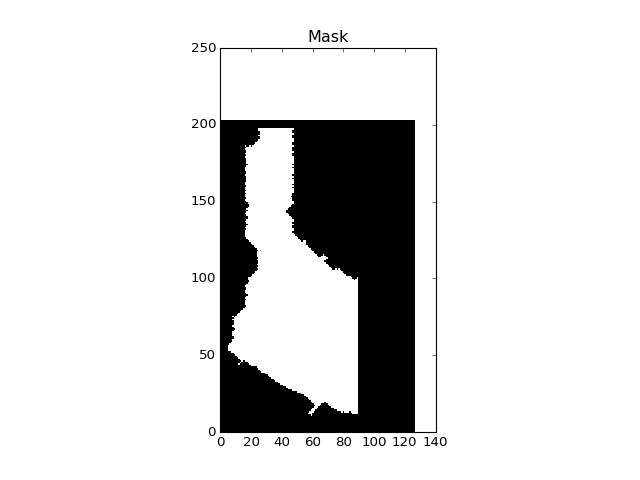

In [579]:
#Make a tissue mask
mask = np.reshape(np.array(grid_df.sum()), (grid_y, grid_x))
mask = np.where(mask>0, 1, 0) #binarize

#Fill the empty pixels
mask = morphology.binary_dilation(mask, morphology.diamond(5))
mask = morphology.binary_erosion(mask, morphology.diamond(5))

#Cut off the bleached area
mask[:,90:] = 0

plt.figure()
plt.pcolor(mask, cmap='gray')
plt.gca().set_aspect('equal')
plt.title('Mask')

In [580]:
# Make the connectivity matrix

#Author: Gioele La Manno
def create_connectivity(mask, kind="queen"):
    """ Create a connectivity matrix of the pixels in a image

    Args
    ----
    mask: np.2darray
        Square image of side N
    kind: str default 'queen
        The kind of connectivity to apply. Can be: rook, bishop, queen (as in chess)

    Returns
    -------
    connectivity_matrix: np.ndarray
        A connectivity matrix (N^2, N^2) where N is the side of mask
    """

    llc = mask.shape[1]
    llc += 2  # add a 1 pixel margin all around the image to simplify the construction (will be removed as last step)
    llr = mask.shape[0]
    llr += 2  # add a 1 pixel margin all around the image to simplify the construction (will be removed as last step)
    cstm_connectivity = np.zeros((llr*llc, llr*llc))  # initialize empty
    pixel_ixs = np.arange(llr*llc)

    # Compute the indexes of the fake edges
    real_pixel_bool = np.ones((llr, llc), dtype=bool)
    real_pixel_bool[0, :] = False
    real_pixel_bool[-1, :] = False
    real_pixel_bool[:, 0] = False
    real_pixel_bool[:, -1] = False
    real_pixel_bool = real_pixel_bool.flat[:]
    real_pixel_ixs = pixel_ixs[real_pixel_bool]
    print(real_pixel_ixs.shape)
    # Neighbour rule
    if kind == "rook":
        neig_relative_ix_pos = np.array([+1, -1, -llc, llc])
    elif kind == "bishop":
        neig_relative_ix_pos = np.array([-llc + 1, llc + 1, -llc - 1, llc - 1])
    elif kind in ["queen", "king"]:
        neig_relative_ix_pos = np.array([+1, -1, -llc, llc, -llc + 1, llc + 1, -llc - 1, llc - 1])

    # Set True at where there is connectivity
    cstm_connectivity[real_pixel_ixs[:, None], real_pixel_ixs[:, None] + neig_relative_ix_pos] = True
    # Is the same as following but using broadcasting
    # for i in real_pixel_ixs:
    #     cstm_connectivity[i, neig_relative_ix_pos+i] = True

    # Remove connectivity entry corresponding to the dummy 1 pixel edges
    cstm_connectivity = cstm_connectivity[real_pixel_ixs[:, None], real_pixel_ixs[None, :]]
    
    return cstm_connectivity

connectivity_matrix = create_connectivity(mask, kind='king')

(25578,)


Average number of cells above the threshold: 296.9428571428571


<IPython.core.display.Javascript object>


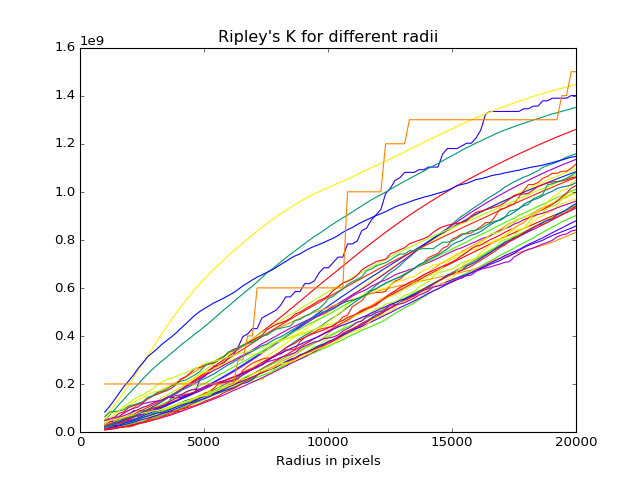

In [581]:
#Select genes based on Ripley's K
def threshold_expression (df, threshold):
    """
    Retruns a dictionary with all the cell labels with an expression above the threshold.
    Input:
    `df`: Data frma with gene expression to use
    `threshold`: Threshold to decide if a cell is positive or negative. 
        Note - For different normalizations different thresholds are needed.
    
    """
    positive_cells = {}
    for i in df.index:
        positive_cells[i] = df.loc[:,df.loc[i] >threshold].columns
    return positive_cells

pos_cell = threshold_expression(df_fish_size_sqrt, .5)
print('Average number of cells above the threshold: {}'.format(np.mean([len(pos_cell[n]) for n in pos_cell])))

#Plot the Riply's of the cells with a expression above the threshold
x_min = coord_df.loc['X'].min()
x_max = coord_df.loc['X'].max()
y_min = coord_df.loc['Y'].min()
y_max = coord_df.loc['Y'].max()
area = ((x_max-x_min)*(y_max-y_min))
Kest = RipleysKEstimator(area, x_max, y_max, x_min, y_min)
radii = np.linspace(1000,20000, 100)

plt.figure()
colors = np.arange(0, 1, 1/df_fish.shape[0])
cmap = matplotlib.cm.get_cmap('prism')

gene_RK_3000 = []
gene_RK_10000 = []
for n, i in enumerate(df_fish.index):
    estimate =  Kest(data=np.array(coord_df.loc[:,pos_cell[i]].T), radii=radii, mode='none')
    gene_RK_3000.append(estimate[np.argmin(np.abs(radii - 3000))]) #Get the estimate of the radii closest to 3000 and append list
    gene_RK_10000.append(estimate[np.argmin(np.abs(radii - 10000))]) #Get the estimate of the radii closest to 10000 and append list
    plt.plot(radii, estimate, color=cmap(colors[n]))

plt.title("Ripley's K for different radii")
plt.xlabel('Radius in pixels')

<IPython.core.display.Javascript object>


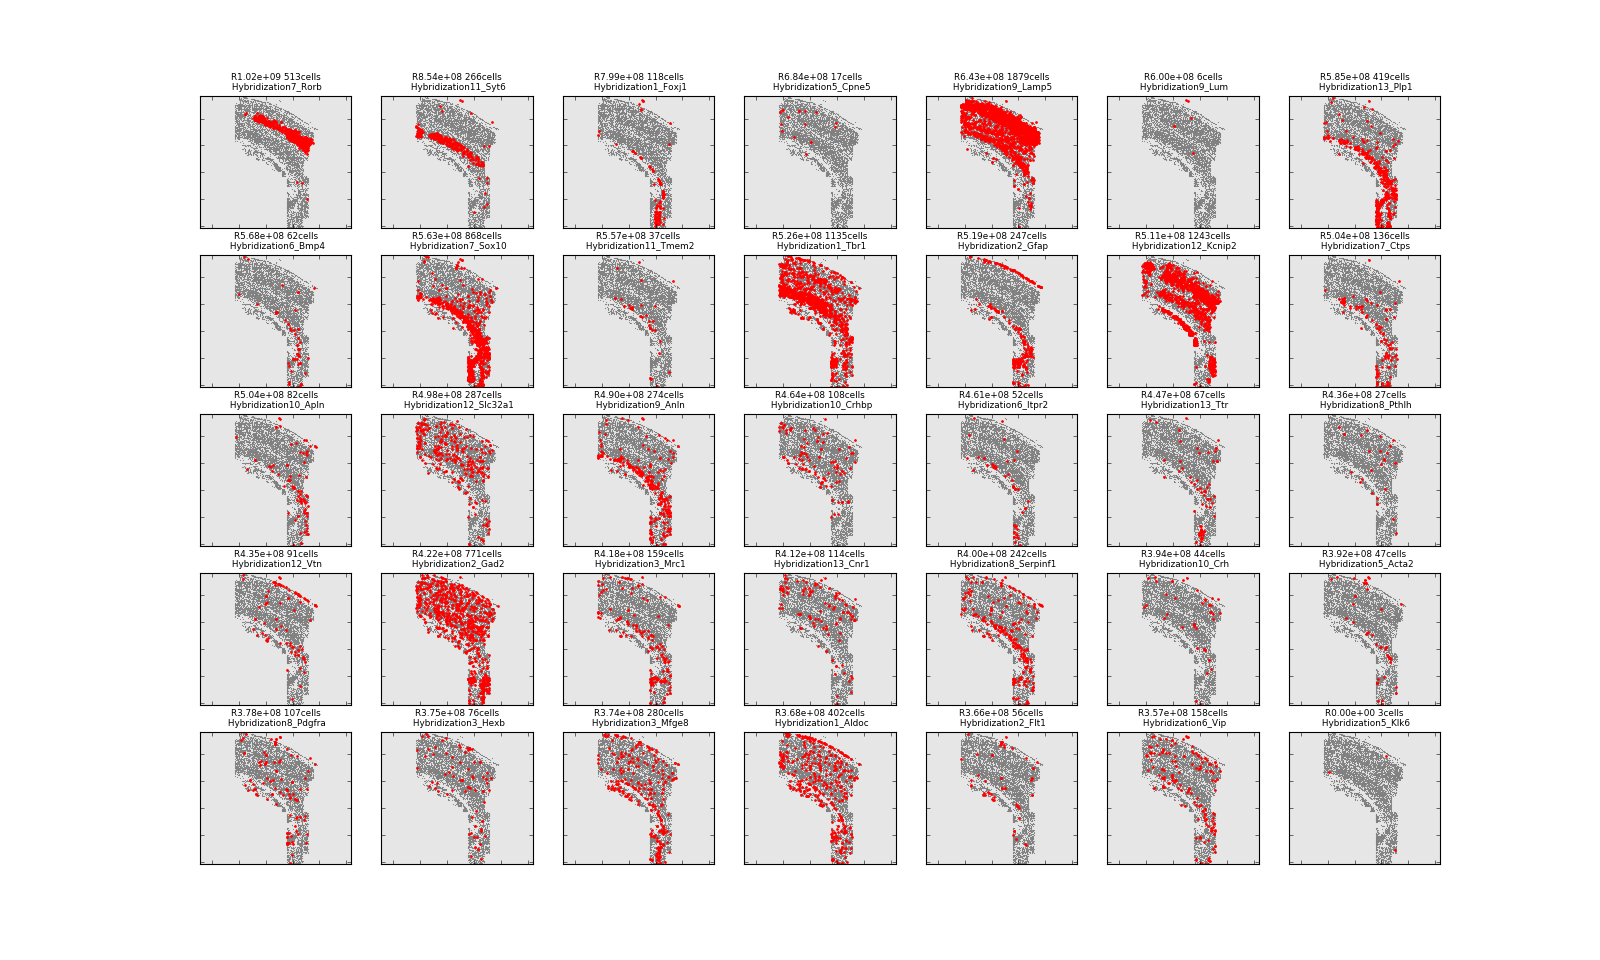

In [582]:
#Sort the genes based on the highest Ripley's K value 
ripley = gene_RK_10000

plt.figure(figsize=(20,12))
n_genes = len(df_fish.index)
gs = plt.GridSpec(5, int(n_genes/5) + (n_genes % 5 > 0))

for i, g in enumerate(np.argsort(ripley)[::-1]):
    gene = df_fish.index[g]
    plt.subplot(gs[i])
    cells = list(pos_cell[gene])
    plot_cell_pos(coord_df, cell_ids=cells, cell_of_interest=None, s=1, standalone=False, color_highlight1='r')
    ax = plt.gca()
    for tl in ax.get_xticklabels() + ax.get_yticklabels():
        tl.set_visible(False)
    #ax.set_title('Cluster {}'.format(c))
    ax.set_title('R{} {}cells\n {}'.format("{:.2e}".format(ripley[g]),len(cells), gene), fontsize=8)
    
n_patterned_genes = len([i for i in ripley if i > 500000000])
patterned_genes = [df_fish.index[i] for i in np.argsort(ripley)[::-1][0:n_patterned_genes]]

<IPython.core.display.Javascript object>


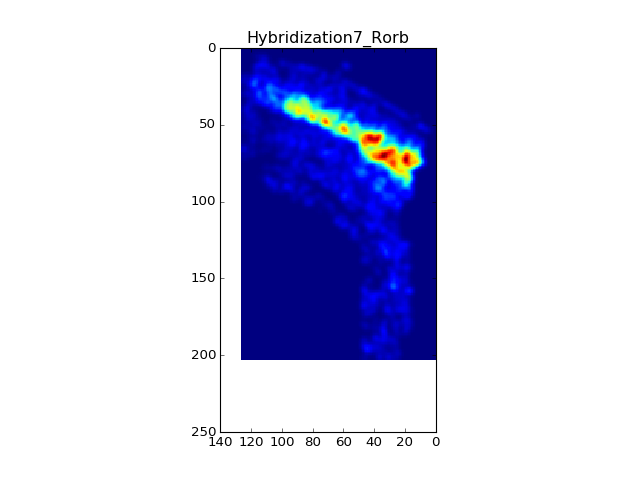

In [614]:
#Smooth the data
def gauss_kern(size, sizey=None): #From Scipy website
    """ Returns a normalized 2D gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    x, y = mgrid[-size:size+1, -sizey:sizey+1]
    g = exp(-(x**2/float(size)+y**2/float(sizey)))
    return g / g.sum()

kernel = gauss_kern(7.5)
grid_df_smooth = grid_df.copy()
for g in grid_df.index:
    g_matrix = grid_df.loc[g].reshape((grid_y, grid_x))
    g_smooth = signal.convolve(g_matrix, kernel, mode='same')
    g_smooth = g_smooth.flatten()
    grid_df_smooth.loc[g] = g_smooth
    
plt.figure()
gene = 'Hybridization7_Rorb'
plt.pcolor(np.reshape(grid_df_smooth.loc[gene],(grid_y, grid_x))) #grid_df_smooth.loc['Hybridization12_Kcnip2']
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.title(gene)

<IPython.core.display.Javascript object>


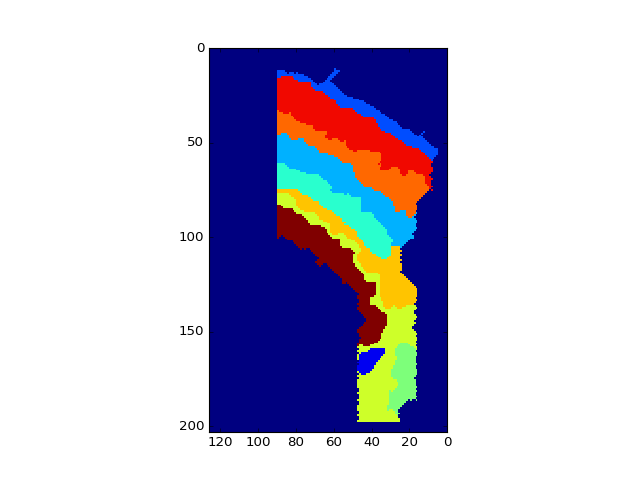

In [615]:
#Remove all the empty tiles
filt = mask.flatten().astype('bool')
grid_df_clean = grid_df_smooth.loc[:,filt]
connectivity_matrix_clean = connectivity_matrix[:,filt]
connectivity_matrix_clean = connectivity_matrix_clean[filt,:]

#Cluster the tiles
data_selection = grid_df_clean.loc[patterned_genes]
#data_selection = grid_df_clean
spat_clust = AgglomerativeClustering(n_clusters=10, connectivity=connectivity_matrix_clean, 
                                    affinity='euclidean', linkage='ward',
                                    compute_full_tree=False).fit(data_selection.T)

#Re-fill the full matrix with the labels and -1 if the tile is empty
labels = np.zeros((1 , grid_y * grid_x))
counter = 0
for n, i in enumerate(filt):
    if i == True:
        labels[:,n] = spat_clust.labels_[counter]
        counter += 1
    else:
        labels[:,n] = -1

tissue_pattern = np.reshape(labels, (grid_y, grid_x))

plt.figure()
plt.pcolor(tissue_pattern, cmap='jet',)
plt.gca().set_aspect('equal')
plt.xlim((0,tissue_pattern.shape[1]))
plt.ylim((0,tissue_pattern.shape[0]))
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()


<IPython.core.display.Javascript object>


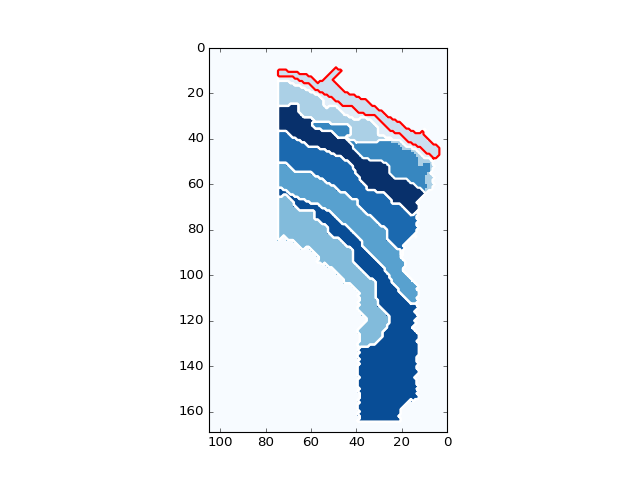

In [504]:

#contour = measure.find_contours(tissue_pattern, 0.5)

def plot_contour(ax, tissue_pattern,  area_of_interest=None, save=False, save_name=None):
    """
    Plot the areas in tissue_pattern and draw contours around them.
    One area can be highlighted in red.
    Input:
    `ax`(matplotlib axis): axis to plot on.
    `tissue_pattern`(numpy array): Tissue image where every pixel is labeled
        by the area label.
    `area_of_interest`(int): Area to highlight.
    `save`(bool): Save the figure as png
    `save_name`(str): Name of the save file. If area_of_interest is highlighted
        the number of the area_of_interest is added.
    
    """
    areas = []
    for i in np.sort(np.unique(tissue_pattern)):
        #if i != -1:
        area = tissue_pattern == i
        areas.append(area)

    
    ax.pcolor(tissue_pattern, cmap='Blues')
    for n, a in enumerate(areas):
        contour = measure.find_contours(a, 0.5)[0]
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, c='w')
    if area_of_interest != None:
        contour = measure.find_contours(areas[area_of_interest+1], 0.5)[0]
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
    

    ax.set_aspect('equal')
    ax.set_xlim((0,tissue_pattern.shape[1]))
    ax.set_ylim((0,tissue_pattern.shape[0]))
    ax.invert_yaxis()
    ax.invert_xaxis()
    if save == True:
        name = save_name + area_of_interest
        plt.savefig('name.png')
        
fix, ax = plt.subplots()
plot_contour(ax,tissue_pattern, 1)

Good Settings:
df: df_fish (counts)
tile size : 300
diamond size: 4
Mask cutoff: 75
gaus kernel: 10
clusters: 8 

df: df_fish (counts)
tile size : 300
diamond size: 4
Mask cutoff: 75
gaus kernel: 8
clusters: 7

#Was this with ventricle? check again!
df: df_fish_size_sqrt
tile size : 300
diamond size: 4
Mask cutoff: 75
gaus kernel: 7
clusters: 9

df: df_fish_size_sqrt
tile size : 250
diamond size: 5
Mask cutoff: 90
gaus kernel: 
clusters: 

## region cell type content

<IPython.core.display.Javascript object>


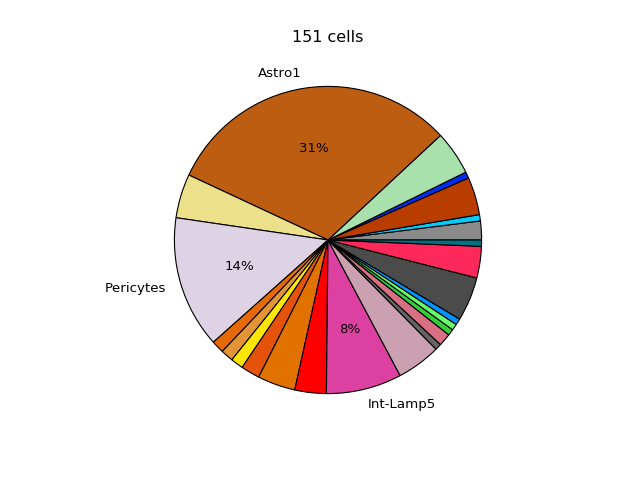

In [404]:
def plot_area_content(ax, tissue_pattern, area_of_interest, type_color_list):
    #Get cells into a dictionary per region
    region_cells = {}
    for i in np.unique(tissue_pattern):
        region_cells[i] = []
    for c in cell_grid.columns:
        reg = tissue_pattern[cell_grid[c]['Y']-1, cell_grid[c]['X']-1]
        region_cells[reg].append(c)

    #substitute the cells for their cell label
    region_types = {}
    for k in region_cells:
        region_types[k] =[cell_labels[i] for i in region_cells[k]]
        
    region = region_types[area_of_interest]
    c = Counter(region)
    percentage = np.array([(i, c[i] / len(region) * 100.0) for i in c])

    type_color_list = [type_color[i] for i in percentage[:,0]]
    for n, i in enumerate(type_color_list):
        type_color_list[n] = [i[0]/255, i[1]/255, i[2]/255]

    pie_labels = []
    for i in percentage:
        if i[1] > 5:
            pie_labels.append(cluster_labels[i[0]])
        else:
            pie_labels.append('')

    '''pie_percentage = []
    for i in percentage:
        if i[1] > 5:
            pie_percentage.append(i[1])
        else:
            pie_percentage.append('')'''

    def my_autopct(pct):
        return ('%.0f%%' % pct) if pct > 5 else ''
    ax.pie(percentage[:,1], colors=type_color_list, labels=pie_labels, autopct=my_autopct)
    ax.set_aspect('equal')   
    ax.set_title('{} cells'.format(len(region)))
    
    
fig, ax = plt.subplots()

plot_area_content(ax, tissue_pattern, 0, type_color_list)

<IPython.core.display.Javascript object>


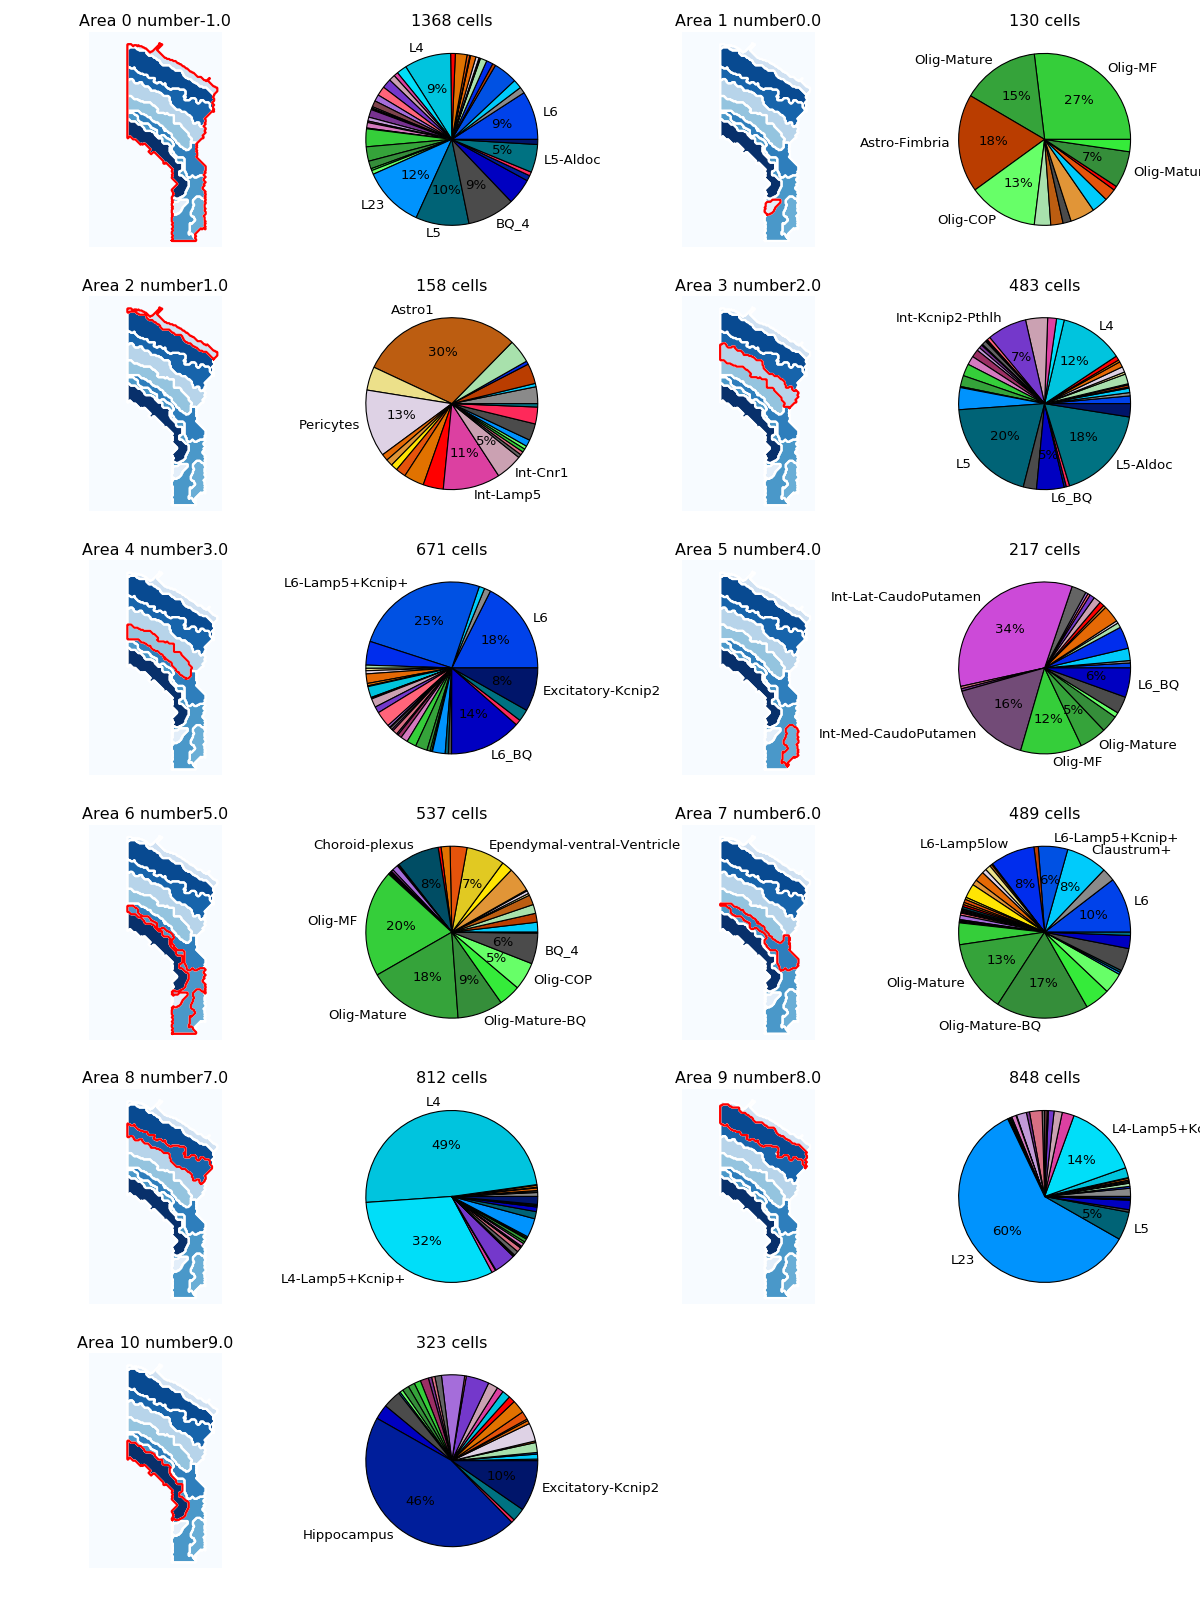

In [616]:
fig = plt.figure(figsize=(15,20))
size_r = math.ceil(len(np.unique(tissue_pattern))/2)

for n, i in enumerate(np.unique(tissue_pattern)): #enumerate([5,2,3,1,4,6,0,7]):
    axl = plt.subplot2grid((size_r, 4), (int(n/2), (n%2)*2), rowspan=1, colspan=1)
    plot_contour(axl, tissue_pattern, area_of_interest=int(i))
    axl.set_title('Area {} number{}'.format(n, i))
    axl.axis('off')
    axr = plt.subplot2grid((size_r, 4), (int(n/2),((n%2)*2)+1), rowspan=1, colspan=1)
    plot_area_content(axr, tissue_pattern, area_of_interest=int(i), type_color_list=type_color_list)
plt.tight_layout()
#plt.savefig('Area_cell_type_content.png', dpi=600)

<IPython.core.display.Javascript object>


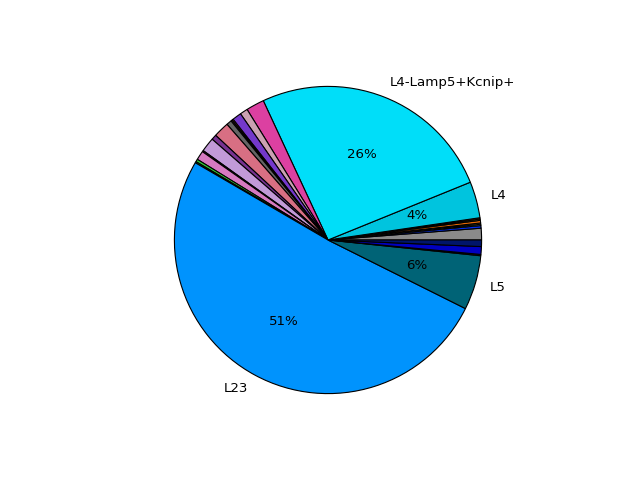

In [260]:


qq = region_types[5]
c = Counter(qq)
percentage = np.array([(i, c[i] / len(qq) * 100.0) for i in c])

type_color_list = [type_color[i] for i in percentage[:,0]]
for n, i in enumerate(type_color_list):
    type_color_list[n] = [i[0]/255, i[1]/255, i[2]/255]
    
pie_labels = []
for i in percentage:
    if i[1] > 3:
        pie_labels.append(cluster_labels[i[0]])
    else:
        pie_labels.append('')

pie_percentage = []
for i in percentage:
    if i[1] > 3:
        pie_percentage.append(i[1])
    else:
        pie_percentage.append('')

def my_autopct(pct):
    return ('%.0f%%' % pct) if pct > 3 else ''
ax.pie(percentage[:,1], colors=type_color_list, labels=pie_labels, autopct=my_autopct)
ax.set_aspect('equal')

In [461]:
l4_cells =  label_cells[18] + label_cells[19]
l23_cells = label_cells[39]

In [475]:
region_cells = {}
for i in np.unique(tissue_pattern):
    region_cells[i] = []
for c in cell_grid.columns:
    reg = tissue_pattern[cell_grid[c]['Y']-1, cell_grid[c]['X']-1]
    region_cells[reg].append(c)

<IPython.core.display.Javascript object>


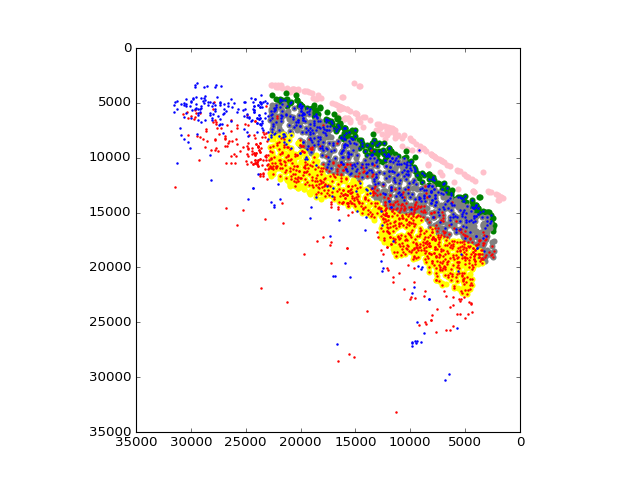

In [497]:
plt.figure()
plt.scatter(coord_df.loc['X',region_cells[0]], coord_df.loc['Y',region_cells[0]], c='pink', s=30, linewidths=0)
plt.scatter(coord_df.loc['X',region_cells[2]], coord_df.loc['Y',region_cells[2]], c='green', s=30, linewidths=0)
plt.scatter(coord_df.loc['X',region_cells[5]], coord_df.loc['Y',region_cells[5]], c='gray', s=30, linewidths=0)
plt.scatter(coord_df.loc['X',region_cells[7]], coord_df.loc['Y',region_cells[7]], c='yellow', s=30, linewidths=0)

plt.scatter(coord_df.loc['X',l4_cells], coord_df.loc['Y',l4_cells], c='red', s=5, linewidths=0)
plt.scatter(coord_df.loc['X',l23_cells], coord_df.loc['Y',l23_cells], c='blue', s=5, linewidths=0)
ax = plt.gca()
ax.set_aspect('equal')
ax.invert_yaxis()
ax.invert_xaxis()